In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##Imports

In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Download Source and Target Images From Google Drive

The data originally comes from Min-h Chuong Huynh's X-Ray Bone Shadow Suppression dataset on Kaggle. 

Link to dataset: https://www.kaggle.com/datasets/hmchuong/xray-bone-shadow-supression

I downloaded the augmented source and target data from there and uploaded them to my Google Drive

### Helper Function - given a zip file path, if it does not exist locally, copy it and unzip

In [ ]:
def copyFromGoogleDriveAndUnzip(gDrivePath):
    zip_filename = gDrivePath.split('/')[-1]
    if not os.path.exists(zip_filename):
        shutil.copyfile(gDrivePath, zip_filename)
        !unzip -q $zip_filename

### Controls

In [ ]:
gDrivePath_source = '/content/gdrive/My Drive/Rib Suppression/source.zip'
gDrivePath_target = '/content/gdrive/My Drive/Rib Suppression/target.zip'

### Download Files From Google Drive

In [ ]:
%%time
copyFromGoogleDriveAndUnzip(gDrivePath_source)
copyFromGoogleDriveAndUnzip(gDrivePath_target)

CPU times: user 854 ms, sys: 4.81 s, total: 5.66 s
Wall time: 41.4 s


Now I have directories labeled source and target with data.

In [ ]:
source_files = os.listdir("source")
target_files = os.listdir("target")
print("{} source files found".format(len(source_files)))
print("{} target files found".format(len(target_files)))

if set(source_files) == set(target_files):
    print("source and target directories have the same filenames.")
else:
    print("source and target directories do not have the same filenames")

4080 source files found
4080 target files found
source and target directories have the same filenames.


The next task is to create the dataset.

## Data Generators

In [ ]:
#given a single image path and an image shape as inputs, resize the image to the specified image shape, normalize the resized image and return it
def read_image_and_resize(image_path, image_shape=[256,256]):
    image = tf.io.read_file(image_path) #read image as jpeg
    image = tf.io.decode_jpeg(image) #convert jpeg to uint8 tensor 
    image = tf.image.resize(image, image_shape, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR) #resize image using nearest neighbor

    image = tf.cast(image, tf.float32) #convert image to float32 tensor from uint8 tensor
    image = image/255.0 #normalize the image
    return image

#use the read_image_and_resize function on source and target images before returning both
def load_source_and_target_images(source_image_path, target_image_path, image_shape=[256,256]):
    source_image = read_image_and_resize(source_image_path, image_shape)
    target_image = read_image_and_resize(target_image_path, image_shape)

    return source_image, target_image

In [ ]:
image_filenames = os.listdir("source")

#split filenames into train, validation and test
train_val_filenames, test_filenames = train_test_split(image_filenames, test_size = 0.1, random_state = 2002)
train_filenames, val_filenames = train_test_split(train_val_filenames, test_size = 0.2, random_state = 2002)

print("There are {} training examples".format(len(train_filenames)))
print("There are {} validation examples".format(len(val_filenames)))
print("There are {} test examples".format(len(test_filenames)))

There are 2937 training examples
There are 735 validation examples
There are 408 test examples


## Enabling easy-to-use and high-performance input pipelines using TensorFlow DataSet

In [ ]:
def create_dataset(filenames, batch_size=16):
    source_file_paths = [os.path.join("source", x) for x in filenames]
    target_file_paths = [os.path.join("target", x) for x in filenames]

    dataset = tf.data.Dataset.from_tensor_slices((source_file_paths, target_file_paths))
    dataset = dataset.shuffle(len(filenames))
    dataset = dataset.map(load_source_and_target_images)  # applying load_source_and_target_images on the whole dataset to convert tuples of filenames to actual images
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

## Creating train, validation and test datasets

In [ ]:
batch_size = 16

train_dataset = create_dataset(train_filenames, batch_size)
val_dataset = create_dataset(val_filenames, batch_size)
test_dataset = create_dataset(test_filenames, batch_size)

In [ ]:
print("There are {} batches in the train dataset".format(len(train_dataset)))
print("There are {} batches in the validation dataset".format(len(val_dataset)))
print("There are {} batches in the test dataset".format(len(test_dataset)))

There are 184 batches in the train dataset
There are 46 batches in the validation dataset
There are 26 batches in the test dataset


Now that I have created the dataset, let me display some random images from the dataset

## Display random examples of training data

In [ ]:
def displayRandomImages(dataset):
    random_index = random.randint(0, (batch_size - 1))
    for item in dataset:
        source_image = item[0][random_index]
        target_image = item[1][random_index]
        break
    
    fig, ax = plt.subplots(1, 2, figsize = (12,6))
    ax[0].imshow(source_image[:,:,0], cmap = 'gray')
    ax[1].imshow(target_image[:,:,0], cmap = 'gray')

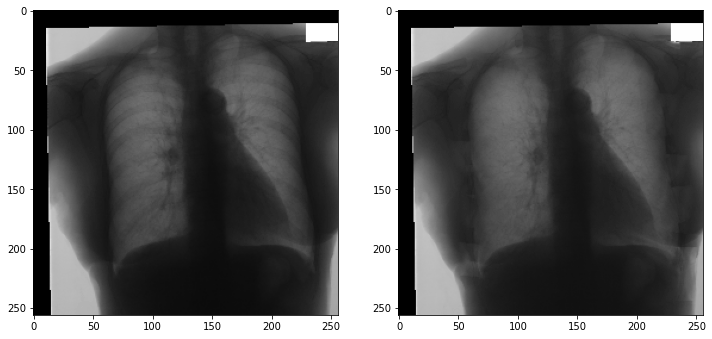

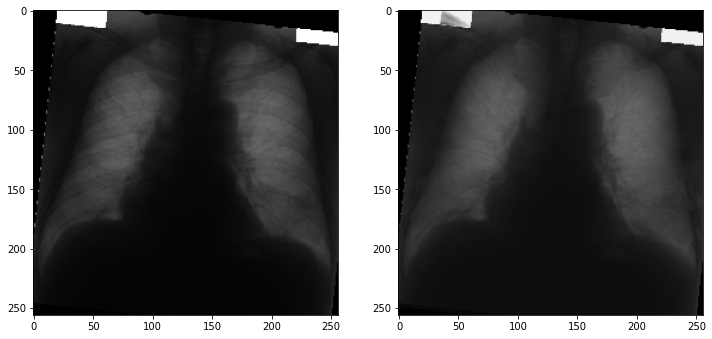

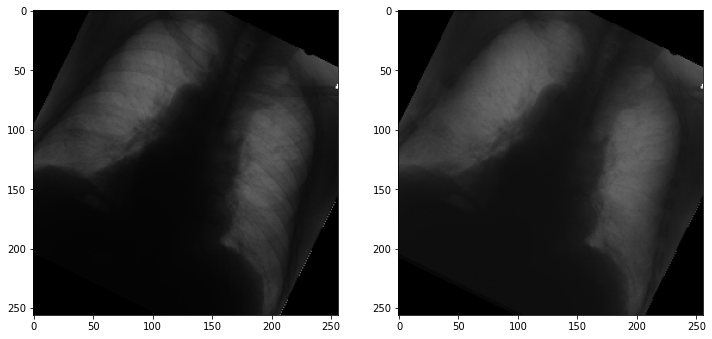

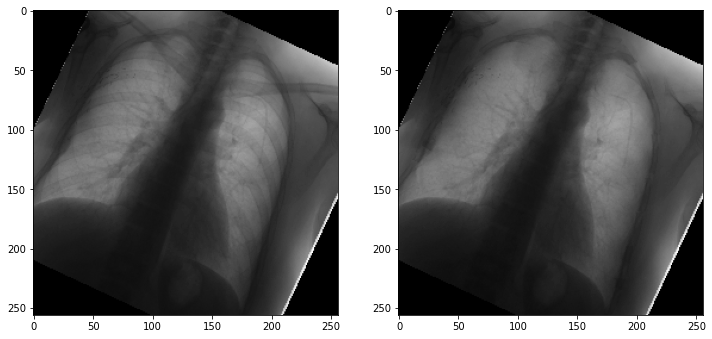

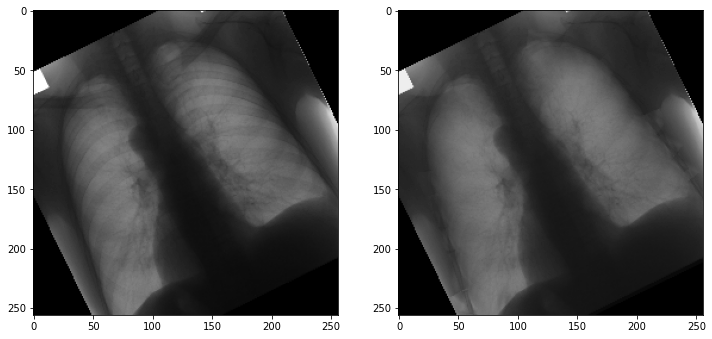

In [ ]:
for i in range(5):
    displayRandomImages(train_dataset)

## Model

In [ ]:
def loss_function(y_true, y_pred):  
    alpha=0.84
    # MSE
    mse = tf.reduce_mean(tf.keras.losses.MSE(y_true, y_pred), 1) 
       
    # MS SSIM
    ssim = tf.reduce_mean(1 - tf.image.ssim_multiscale(y_true, y_pred, 1))

    # Mixed cost
    loss = alpha * ssim + (1 - alpha) * mse

    return loss

def create_model(num_filters=64, num_res_blocks=16, res_block_scaling=None):
    x_in = tf.keras.layers.Input(shape=(256,256,1))
    x = b = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(x_in)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = tf.keras.layers.Conv2D(num_filters, (3, 3), padding='same')(b)
    x = tf.keras.layers.Add()([x, b])
    x = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(x)
    return tf.keras.Model(x_in, x, name="ResNet-BS")

def res_block(x_in, filters, scaling):
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x_in)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same')(x)
    if scaling:
        x = tf.keras.layers.Lambda(lambda t: t * scaling)(x)
    x = tf.keras.layers.Add()([x_in, x])
    return x

resnet_bs_model = create_model(num_filters=64, num_res_blocks=16, res_block_scaling=0.1)
resnet_bs_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=loss_function) 

Reference used for loss function: https://arxiv.org/pdf/1511.08861.pdf 

In [ ]:
EPOCHS = 20

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_lr=0.00001)
callbacks_list = [earlyStopping, reduce_lr]

history = resnet_bs_model.fit(train_dataset,
                              batch_size=batch_size,
                              epochs = EPOCHS,
                              verbose = 1,
                              callbacks=callbacks_list,
                              shuffle=True,
                              validation_data = val_dataset)

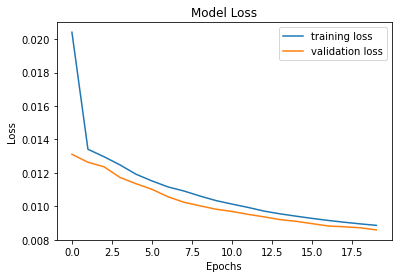

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["training loss", "validation loss"], loc = "upper right")

## Save Model

In [ ]:
model_save_path = "Rib_Suppression_Model_ResNet.h5"
resnet_bs_model.save(model_save_path, include_optimizer = False)

## Load Model

In [ ]:
model_from_disk = tf.keras.models.load_model("Rib_Suppression_Model_ResNet.h5", compile = False)
predictions = model_from_disk.predict(test_dataset)
print(predictions.shape)

In [ ]:
def display_random_images_and_prediction(dataset, predictions):
    random_index = random.randint(0, (batch_size - 1))
    for item in dataset:
        source_image = item[0][random_index]
        target_image = item[1][random_index]
        predicted_image = predictions[random_index, :, :, 0]
        break
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    ax[0].imshow(source_image[:,:,0], cmap = "gray")
    ax[0].set_title("Source Image")
    ax[1].imshow(target_image[:,:,0], cmap = "gray")
    ax[1].set_title("Target Image")
    ax[2].imshow(predicted_image, cmap = "gray")
    ax[2].set_title("Predicted Image")

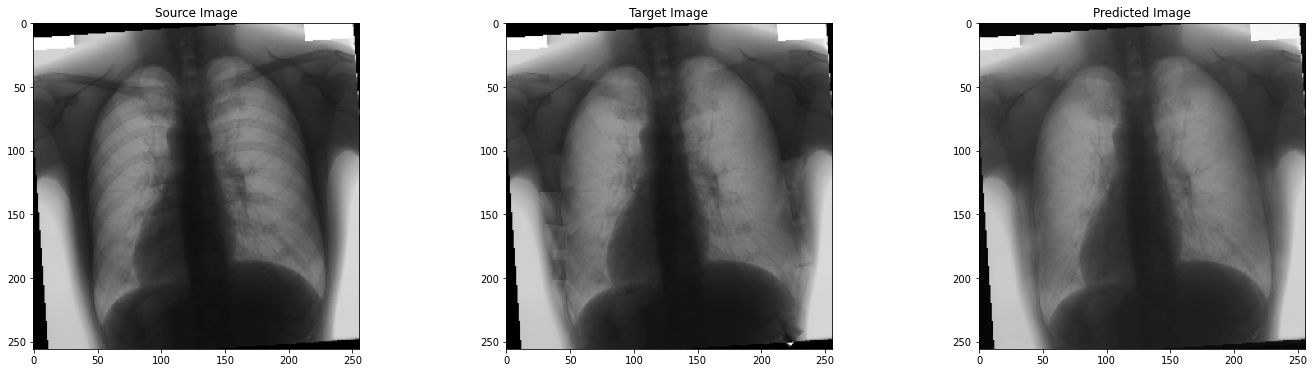

In [ ]:
display_random_images_and_prediction(test_dataset, predictions)

## Try Using CXRs found online

In [ ]:
from PIL import Image
import requests

In [ ]:
def download_online_image_and_resize(url, image_shape=[256,256]):
    image = np.array(Image.open(requests.get(url, stream = True).raw))
    height, width = image.shape
    image = np.reshape(image, [height, width, 1])
    image = tf.image.resize(image, image_shape, method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image

In [ ]:
cxr_url = 'http://www.meddean.luc.edu/lumen/meded/radio/curriculum/Pulmonary/image.jpg'

In [ ]:
input_image = download_online_image_and_resize(cxr_url)
rib_suppressed_image = model_from_disk.predict(np.expand_dims(input_image, axis = 0))

In [ ]:
rib_suppressed_image.shape

(1, 256, 256, 1)

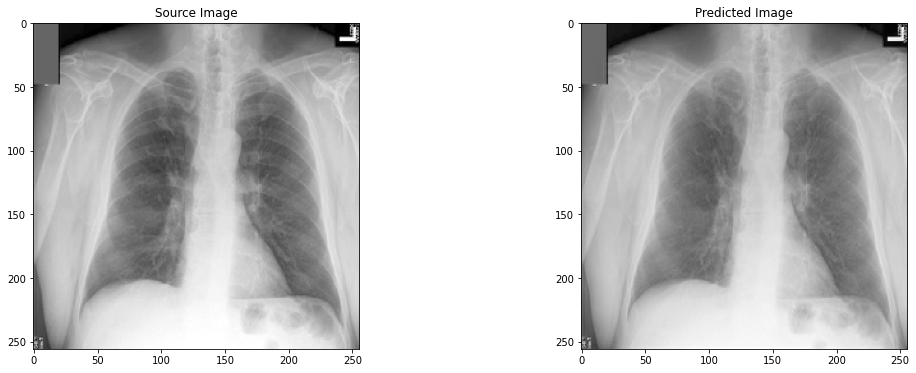

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].imshow(input_image[:,:,0], cmap = "gray")
ax[0].set_title("Source Image")
ax[1].imshow(rib_suppressed_image[0,:,:,0], cmap = "gray")
ax[1].set_title("Predicted Image")
plt.show()